# <center>Homework 2</center>
## Authors
### Abdullah Alkhalifah 201690090
### Ibrahim Alzekri 201616860
In this notebook we will design, model, and train a neural network to classify points whether they are inside the blue shape given below or not.

![](https://drive.google.com/uc?export=view&id=14tsQTsWjcY-LV5TQ3hxfYt1OQs6UsQdP)

### i. Design

![](https://drive.google.com/uc?export=view&id=1x6mw7pwRf6_wEE0y6LZ97j3DE5E-WG0v)

### ii. Model Designed MLP
Now, we will design an MLP model based on the previous weights and biases to simulate our shape


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

print(torch.__version__)

1.6.0+cu101


In [2]:
class blue_shape_classifier(nn.Module):
    '''
    Demo classifier model class to demonstrate SiLU
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.input = nn.Linear(2, 8)
        self.h1_a = nn.Linear(4, 1)
        self.h1_b = nn.Linear(4, 1)
        self.h2 = nn.Linear(2, 1)

        self.intialize_params()


    def forward(self, x):

        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = self.step(self.input(x))

        x_a = self.step(self.h1_a(x[:,0:4].float()))
        x_b = self.step(self.h1_b(x[:,4:8].float()))
        
        x = torch.cat((x_a, x_b), dim=1)
        
        output = self.step(self.h2(x.float()))

        return output
    
    def intialize_params(self):        
        
        
        old_params = {}

        for name, params in self.named_parameters():
            old_params[name] = params.clone()


        old_params['input.weight'] = [ [1 , -1], [1, 1], [-1, 1], [-1, -1], [1, 1], [1, -1], [-1, 1], [-1, -1] ]                
        old_params['input.bias'] = [8, 8, 0, 0, 0, 0, 8, 8]


        old_params['h1_a.weight'] = [1 , 1, 1, 1]
        old_params['h1_a.bias'] = [-4]

        old_params['h1_b.weight'] = [1 , 1, 1, 1]
        old_params['h1_b.bias'] = [-4]
        
        old_params['h2.weight'] = [1 , 1]
        old_params['h2.bias'] = [-1]

        for name, params in self.named_parameters():
            params.data.copy_(torch.tensor(old_params[name]))


    def step (self, x):
        return (x>=0)*1

### iii. Sampling

We will create uniform data points $(x_1,x_2)$ inside an imaginary surronding rectangular with points (10,6), (10,-6), (-10,6), (-10,-6) in order to have a balanced dataset. We will also generate y (class) values base on $|(x_1-4)|+|x_2|=4$ and $|(x_1+4)|+|x_2|=4$

In [3]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes

    x1 = np.random.uniform(low= -10 , high= 10, size=n).reshape(-1,1)
    x2 = np.random.uniform(low= -6 , high= 6, size=n).reshape(-1,1)
    y = ( abs(x1-4)+abs(x2) <= 4 ).astype(int).reshape(-1) + ( abs(x1+4)+abs(x2) <= 4 ).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [4]:
# Generate the data

x_train,y_train = sample_points(10000)
x_val,y_val = sample_points(500)
x_test,y_test = sample_points(500)

print(x_train.shape,y_train.shape)

(10000, 2) (10000,)


In [5]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

### iv. Testing

Firstly, we will develope a print funaction to plot Blus Shape model results

In [6]:
def print_BS_model(net, datapoints):

  out = net(datapoints)

  green = datapoints.numpy()[np.where(out==1)[0]]
  red = datapoints.numpy()[np.where(out==0)[0]]
  
  fig, ax = plt.subplots()

  plt.xlim((-10,10))
  plt.ylim((-6,6))

  rect1 = patches.Rectangle((0,0), 5.65685,5.65685,lw=1.0,edgecolor='b',fc='none')
  rect2 = patches.Rectangle((0,0), 5.65685,5.65685,lw=1.0,edgecolor='b',fc='none')

  t1 = mpl.transforms.Affine2D().rotate_deg(-45) + ax.transData
  rect1.set_transform(t1)
  t2 = mpl.transforms.Affine2D().rotate_deg(135) + ax.transData
  rect2.set_transform(t2)

  pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
  neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

  ax.add_patch(rect1)
  ax.add_patch(rect2)
  ax.add_artist(pos_values)
  ax.add_artist(neg_values)

In [29]:
def accuracy(net, test_data, y):

    correct = 0
    out = net(test_data)
    for i in range(out.shape[0]):
        if(out[i][0] == y[i]):
            correct = correct + 1

    accuracy = correct/torch.numel(y) * 100
    return accuracy

The accuraacy is: 100.0%


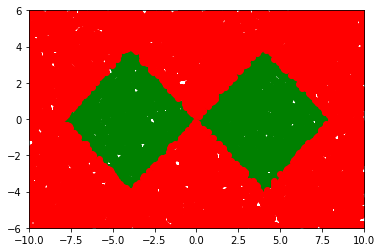

In [35]:
bs_model = blue_shape_classifier()
print_BS_model(bs_model,x_train)

print('The accuraacy is: '+str(accuracy(bs_model, x_test, y_test))+'%')



### Method for ploting figures used in coming exercises 

In [9]:
def print_figure(net, datapoints):

  out = net(datapoints).argmax(dim=1).detach().numpy()
  green = datapoints.numpy()[np.where(out==1)]
  red = datapoints.numpy()[np.where(out==0)]

  fig, ax = plt.subplots()

  plt.xlim((-10,10))
  plt.ylim((-6,6))

  rect1 = patches.Rectangle((0,0), 5.65685,5.65685,lw=1.0,edgecolor='b',fc='none')
  rect2 = patches.Rectangle((0,0), 5.65685,5.65685,lw=1.0,edgecolor='b',fc='none')

  t1 = mpl.transforms.Affine2D().rotate_deg(-45) + ax.transData
  rect1.set_transform(t1)
  t2 = mpl.transforms.Affine2D().rotate_deg(135) + ax.transData
  rect2.set_transform(t2)

  pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
  neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

  ax.add_patch(rect1)
  ax.add_patch(rect2)
  ax.add_artist(pos_values)
  ax.add_artist(neg_values)

### Part V and onwards
Now we will build an MLP with only one hidden layer for parts V and VI


In [10]:
class Net(nn.Module):

  def __init__(self,hidden_size): # hidden_size only to use this module for part 5 and 6
    super(Net,self).__init__()
    self.layer1 = nn.Linear(2,hidden_size)
    self.act = nn.ReLU()
    self.layer3 = nn.Linear(hidden_size,2)

  def forward(self,x):
    x = self.layer1(x)
    x = self.act(x)
    return self.layer3(x)


This is our main training function.
It will be used in parts V, VI and VII

In [11]:
def train_net(net,train_set,val_set,n_iters,gpu):

    train_data,train_labels = train_set
    val_data,val_labels = val_set
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # should we move them to gpu?
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() 
        print("Using GPU")
    else:
        print("Using CPU")

    for epoch in range(n_iters):
      #zero the gradients
      optimizer.zero_grad()

      #compute foward, backward and optimize 
      output = net(train_data)
      loss = criterion(output,train_labels)
      loss.backward()
      optimizer.step()

      if epoch%500==499: # every 500 iterations, print statistics
          print("epoch #: ",epoch+1)
          # accuracy of the train prediction
          train_prediction = output.cpu().detach().argmax(dim=1)
          train_accuracy = (train_prediction.numpy()==train_labels.cpu().detach().numpy()).mean()
          # accuracy of the validation prediction
          with torch.no_grad():
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            val_prediction = val_output.cpu().detach().argmax(dim=1)
            val_accuracy = (val_prediction.numpy()==val_labels.cpu().detach().numpy()).mean()
          print("Training loss :",loss.cpu().detach().numpy())
          print("Training accuracy :",train_accuracy)
          print("Validation loss :",val_loss.cpu().detach().numpy())
          print("Validation accuracy :",val_accuracy)
          print('='*20)

part V

In [12]:
device = torch.cuda.is_available()
print(device)
net8 = Net(8) # initiate the model with 8 neurons

False


In [13]:
train_set = (x_train,y_train)
val_set = (x_val,y_val)
train_net(net8,train_set,val_set,10000,device)

Using CPU
epoch #:  500
Training loss : 0.41289043
Training accuracy : 0.7574
Validation loss : 0.41158596
Validation accuracy : 0.766
epoch #:  1000
Training loss : 0.37729573
Training accuracy : 0.8075
Validation loss : 0.37606928
Validation accuracy : 0.826
epoch #:  1500
Training loss : 0.35305306
Training accuracy : 0.8293
Validation loss : 0.35192338
Validation accuracy : 0.848
epoch #:  2000
Training loss : 0.3354782
Training accuracy : 0.8397
Validation loss : 0.33401033
Validation accuracy : 0.85
epoch #:  2500
Training loss : 0.32282895
Training accuracy : 0.8466
Validation loss : 0.32069936
Validation accuracy : 0.86
epoch #:  3000
Training loss : 0.31393212
Training accuracy : 0.8534
Validation loss : 0.31147873
Validation accuracy : 0.856
epoch #:  3500
Training loss : 0.30750546
Training accuracy : 0.8562
Validation loss : 0.30501702
Validation accuracy : 0.856
epoch #:  4000
Training loss : 0.3026093
Training accuracy : 0.8613
Validation loss : 0.3002624
Validation accur

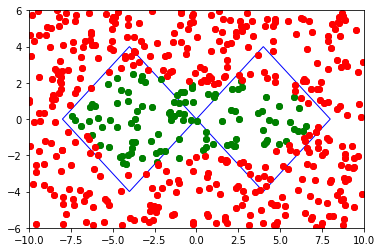

In [14]:
with torch.no_grad():
  print_figure(net8,x_test)

Part VI

In [15]:
net50 = Net(50) # initiate the model with 50 neurons

In [16]:
train_net(net50,train_set,val_set,10000,device)

Using CPU
epoch #:  500
Training loss : 0.3599861
Training accuracy : 0.8127
Validation loss : 0.3568126
Validation accuracy : 0.838
epoch #:  1000
Training loss : 0.3166529
Training accuracy : 0.8545
Validation loss : 0.31211147
Validation accuracy : 0.864
epoch #:  1500
Training loss : 0.29269344
Training accuracy : 0.8696
Validation loss : 0.28689685
Validation accuracy : 0.868
epoch #:  2000
Training loss : 0.27604118
Training accuracy : 0.8839
Validation loss : 0.2684397
Validation accuracy : 0.874
epoch #:  2500
Training loss : 0.26287583
Training accuracy : 0.8928
Validation loss : 0.25306612
Validation accuracy : 0.878
epoch #:  3000
Training loss : 0.251335
Training accuracy : 0.9016
Validation loss : 0.23974092
Validation accuracy : 0.88
epoch #:  3500
Training loss : 0.24182083
Training accuracy : 0.908
Validation loss : 0.22873622
Validation accuracy : 0.896
epoch #:  4000
Training loss : 0.23389356
Training accuracy : 0.9114
Validation loss : 0.2198613
Validation accuracy 

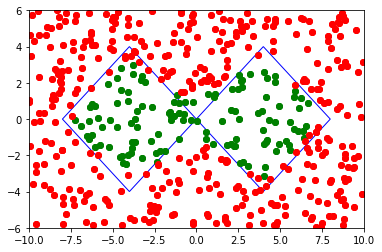

In [17]:
with torch.no_grad():
  print_figure(net50,x_test)

Since only four decison boundaries are needed for a clasification of a square (8 here for two squares), we don't see significant imporvment in the accuarcy of the datasets.


Part VII

In [18]:
# create a sequintial model with 2 hidden layers
net82 = nn.Sequential(nn.Linear(2,8),nn.ReLU(),nn.Linear(8,2),nn.ReLU(),nn.Linear(2,2))

In [19]:
train_net(net82,train_set,val_set,10000,device)

Using CPU
epoch #:  500
Training loss : 0.5337182
Training accuracy : 0.6779
Validation loss : 0.52860814
Validation accuracy : 0.686
epoch #:  1000
Training loss : 0.45522925
Training accuracy : 0.7415
Validation loss : 0.44967487
Validation accuracy : 0.738
epoch #:  1500
Training loss : 0.36700407
Training accuracy : 0.8029
Validation loss : 0.36412573
Validation accuracy : 0.822
epoch #:  2000
Training loss : 0.32764867
Training accuracy : 0.8459
Validation loss : 0.3246679
Validation accuracy : 0.85
epoch #:  2500
Training loss : 0.29995403
Training accuracy : 0.8649
Validation loss : 0.2975328
Validation accuracy : 0.864
epoch #:  3000
Training loss : 0.27879003
Training accuracy : 0.8815
Validation loss : 0.27713045
Validation accuracy : 0.886
epoch #:  3500
Training loss : 0.26143718
Training accuracy : 0.8934
Validation loss : 0.25935748
Validation accuracy : 0.89
epoch #:  4000
Training loss : 0.24743848
Training accuracy : 0.9025
Validation loss : 0.24339062
Validation accur

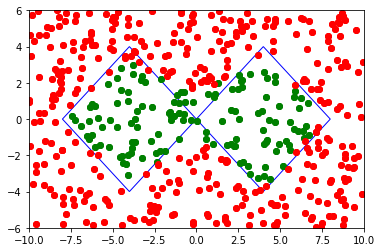

In [20]:
with torch.no_grad():
  print_figure(net82,x_test)

Since we have two layers now and 8 neurons, this model is even better.

the first hidden layer will calssifiy the descion boundaries, but here, unlike part V & VI, we have another layer to 'And' the two squares created. Thus, we will get a better classification.

Note: not a subsational increase due to the nature of this problem.